In [426]:
# --- Imports and Path Definitions ---

import json
import re
import ast
import inspect
import importlib.util
from pathlib import Path
from types import ModuleType
from typing import Callable, Any, Dict, List, Set
from fractions import Fraction as BuiltinFraction
import copy
import datetime

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datasets import load_dataset, Dataset
from joblib import Parallel, delayed

def find_project_root(marker: str = ".git"):
    """
    Traverses the directory structure upwards from the current working directory
    to locate the project's root, which is identified by the presence of a
    specific marker file or directory (e.g., '.git').

    Args:
        marker: The filename or directory name that marks the project root.

    Returns:
        A Path object to the project root directory.
    
    Raises:
        FileNotFoundError: If the project root cannot be found.
    """
    current_path = Path.cwd().resolve()
    while current_path != current_path.parent:
        if (current_path / marker).exists():
            return current_path
        current_path = current_path.parent
    raise FileNotFoundError(f"Could not find project root. Marker '{marker}' not found.")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data'

# --- Directory Paths ---
PROCESSED_TEMPLATE_DIR = DATA_DIR / "template-generated-processed"
CONCEPTUAL_CANDIDATES_DIR = DATA_DIR / "conceptual-error-candidates"
CATALOG_PATH = CONCEPTUAL_CANDIDATES_DIR / "conceptual_candidate_catalog.csv"

# --- Models ---
MODELS = ['google_gemini-2.5-flash', 'openai_gpt-4.1']

print(f"Project root: {PROJECT_ROOT}")
print(f"Input (Processed Templates): {PROCESSED_TEMPLATE_DIR}")
print(f"Output (Conceptual Candidates): {CONCEPTUAL_CANDIDATES_DIR}")
print(f"Catalog Path: {CATALOG_PATH}")

# --- Ensure Directories Exist ---
PROCESSED_TEMPLATE_DIR.mkdir(parents=True, exist_ok=True)
CONCEPTUAL_CANDIDATES_DIR.mkdir(parents=True, exist_ok=True)

catalog = pd.read_csv(CATALOG_PATH)
print(catalog.info())

Project root: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math
Input (Processed Templates): /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/template-generated-processed
Output (Conceptual Candidates): /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/conceptual-error-candidates
Catalog Path: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/conceptual-error-candidates/conceptual_candidate_catalog.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   index                  33716 non-null  int64 
 1   tier                   33716 non-null  object
 2   model                  33716 non-null  object
 3   mutation_type          33716 non-null  object
 4   erroneous_line_number  33496 non-null  object
 5   target_variable        33716 non-null  object
 6   correct_value          3

In [427]:
programmatic_validation = pd.read_csv(PROCESSED_TEMPLATE_DIR / "template_validation_report.csv")

# get indices of all rows that have semantic_score of 1.0, structural_score of 1.0
semantic_pass_indices = programmatic_validation[programmatic_validation['semantic_score'] == 1.0]['index'].unique().tolist()
structural_pass_indices = programmatic_validation[programmatic_validation['structural_score'] == 1.0]['index'].unique().tolist()

# make catalogs with only the semantic and structural pass indices
semantic_catalog = catalog[catalog['index'].isin(semantic_pass_indices)].reset_index(drop=True)
structural_catalog = catalog[catalog['index'].isin(structural_pass_indices)].reset_index(drop=True)

# print value counts of mutation types in the semantic and structural catalogs
print(f"Number of semantic pass indices: {semantic_catalog['index'].nunique()}")
print(f"Number of semantic pass candidates: {len(semantic_catalog)}")
print("Semantic Catalog Mutation Types:")
print(semantic_catalog['mutation_type'].value_counts())
print()

print(f"Number of structural pass indices: {structural_catalog['index'].nunique()}")
print(f"Number of structural pass candidates: {len(structural_catalog)}")
print("Structural Catalog Mutation Types:")
print(structural_catalog['mutation_type'].value_counts())
print()

print(f"Total number of indices in the catalog: {catalog['index'].nunique()}")
print(f"Total number of candidates in the catalog: {len(catalog)}")
print("Total catalog mutation types:")
print(catalog['mutation_type'].value_counts())

Number of semantic pass indices: 6057
Number of semantic pass candidates: 28378
Semantic Catalog Mutation Types:
mutation_type
incorrect_final_answer_selection    8235
input_misrepresentation             7473
incorrect_operand                   6569
operator_swap                       5703
incomplete_calculation               398
Name: count, dtype: int64

Number of structural pass indices: 6582
Number of structural pass candidates: 30850
Structural Catalog Mutation Types:
mutation_type
incorrect_final_answer_selection    8940
input_misrepresentation             8127
incorrect_operand                   7200
operator_swap                       6149
incomplete_calculation               434
Name: count, dtype: int64

Total number of indices in the catalog: 7197
Total number of candidates in the catalog: 33716
Total catalog mutation types:
mutation_type
incorrect_final_answer_selection    9765
input_misrepresentation             8860
incorrect_operand                   7882
operator_swap  

In [428]:
# drop all rows with null 'erroneous_line_number' from the semantic catalog
semantic_catalog = semantic_catalog.dropna(subset=['erroneous_line_number']).reset_index(drop=True)

# print the number of rows in which the 'erroneous_line_number' is null in the semantic catalog
null_line_count = semantic_catalog['erroneous_line_number'].isnull().sum()
print(f"Number of rows with null 'erroneous_line_number': {null_line_count}")

Number of rows with null 'erroneous_line_number': 0


In [429]:
import random

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [430]:
from collections import defaultdict

def get_relative_position_bin(ratio):
    """
    Converts a relative position ratio to a bin label.
    """
    if pd.isna(ratio):
        return 'unknown'
    elif ratio <= 0.33:
        return 'early'
    elif ratio <= 0.66:
        return 'middle'
    else:
        return 'late'

def add_relative_position_info(df):
    """
    Adds relative position information to the dataframe.
    """
    # Load GSM8K dataset if not already loaded
    GSM8K_TRAIN = load_dataset("gsm8k", "main")["train"]
    
    def sanitize_text(text: str) -> str:
        return text.strip()
    
    def get_solution_line_count(index: int):
        try:
            solution_text = GSM8K_TRAIN[index]["answer"]
            sanitized_text = sanitize_text(solution_text)
            lines = [ln.strip() for ln in sanitized_text.splitlines()]
            
            # Remove FA line if present
            if lines and re.match(r"^####\s*[\d\.,]+$", lines[-1]):
                lines.pop(-1)
            
            return len(lines)
        except IndexError:
            return 0
    
    def extract_line_number(erroneous_line_str):
        # Handle NaN and non-string values properly
        if pd.isna(erroneous_line_str) or erroneous_line_str == "FA":
            return None
        # Convert to string and extract the second character as integer
        try:
            str_val = str(erroneous_line_str)
            if len(str_val) < 2:
                return None
            return int(str_val[1])
        except (ValueError, IndexError):
            return None
    
    # Add columns
    df_copy = df.copy()
    
    print("Computing relative position information...")
    line_counts = []
    error_line_numbers = []
    ratios = []
    position_bins = []
    
    for idx, row in tqdm(df_copy.iterrows(), total=len(df_copy)):
        gsm8k_index = row['index']
        erroneous_line_str = row['erroneous_line_number']
        
        # Get solution line count
        line_count = get_solution_line_count(gsm8k_index)
        line_counts.append(line_count)
        
        # Extract numeric error line number
        error_line_num = extract_line_number(erroneous_line_str)
        error_line_numbers.append(error_line_num)
        
        # Compute ratio and bin
        if error_line_num is not None and line_count > 0:
            ratio = error_line_num / line_count
            ratios.append(ratio)
            position_bins.append(get_relative_position_bin(ratio))
        else:
            ratios.append(None)
            position_bins.append('final_answer' if erroneous_line_str == 'FA' else 'unknown')
    
    df_copy['solution_line_count'] = line_counts
    df_copy['error_line_numeric'] = error_line_numbers
    df_copy['error_position_ratio'] = ratios
    df_copy['position_bin'] = position_bins
    
    return df_copy

def get_tier_position_bin_indices(df: pd.DataFrame, mutation_type: str):
    """
    Returns a dict mapping (tier, position_bin) pairs to lists of indices
    """
    if mutation_type not in df['mutation_type'].unique():
        return {}

    # Filter the DataFrame for the given mutation type
    filtered_df = df[df['mutation_type'] == mutation_type]

    # Group by (tier, position_bin) and collect indices
    tier_position_indices = filtered_df.groupby(['tier', 'position_bin'])['index'].unique().apply(list).to_dict()

    # Sort in ascending order of list length
    sorted_tier_position_indices = dict(sorted(tier_position_indices.items(), key=lambda item: len(item[1])))

    dict_to_return = defaultdict(list)
    # Successively remove indices that appear in previous (tier, position_bin) pairs
    for (tier, position_bin), indices in sorted_tier_position_indices.items():
        previous_indices = set().union(*list(dict_to_return.values())) if dict_to_return else set()
        filtered_indices = [idx for idx in indices if idx not in previous_indices]
        dict_to_return[(tier, position_bin)] = filtered_indices

    # Sort again in ascending order of list length
    dict_to_return = dict(sorted(dict_to_return.items(), key=lambda item: len(item[1])))

    return dict_to_return

def sample_indices_by_tier_and_position(
    df: pd.DataFrame, 
    mutation_type: str,
    num_indices_needed: int,
    random_seed: int = 42
) -> pd.DataFrame:
    """
    Samples indices based on (tier, position_bin) pair counts and the number of indices needed.
    """
    tier_position_indices = get_tier_position_bin_indices(df, mutation_type)
    print(f"Total (tier, position_bin) pairs: {len(tier_position_indices)}")
    print(f"Target total indices: {num_indices_needed}")
    
    # Set random seed for reproducibility
    random.seed(random_seed)

    # Group by tier for better visualization
    tier_summary = defaultdict(lambda: {'pairs': 0, 'total_indices': 0})
    position_summary = defaultdict(int)
    
    for (tier, position_bin), indices in tier_position_indices.items():
        tier_summary[tier]['pairs'] += 1
        tier_summary[tier]['total_indices'] += len(indices)
        position_summary[position_bin] += len(indices)
        print(f"  {tier}, {position_bin}: {len(indices)} candidate indices")
    
    print(f"\nTier summary:")
    for tier, summary in tier_summary.items():
        print(f"  {tier}: {summary['pairs']} pairs, {summary['total_indices']} total indices")
    
    print(f"\nPosition summary:")
    for position, count in position_summary.items():
        print(f"  {position}: {count} total indices")

    filtered_df = df[df['mutation_type'] == mutation_type].reset_index(drop=True)
    remaining_pairs = list(tier_position_indices.keys())
    mean = num_indices_needed // len(remaining_pairs) if remaining_pairs else 0
    print(f"Initial mean per (tier, position_bin) pair: {mean}")

    df_to_return = pd.DataFrame(columns=filtered_df.columns)
    total_selected = 0

    for (tier, position_bin), indices in tier_position_indices.items():
        print(f"\nProcessing {tier}, {position_bin} ({len(indices)} indices available)")
        
        # Sample indices
        if len(indices) <= mean:
            sampled_indices = indices.copy()
            print(f"  Taking all {len(sampled_indices)} indices (less than or equal to mean {mean})")
        else:
            sampled_indices = sorted(random.sample(indices, mean))
            print(f"  Randomly selecting {len(sampled_indices)} indices (more than mean {mean})")

        # Update remaining calculation
        remaining_pairs.remove((tier, position_bin))
        num_indices_needed -= len(sampled_indices)
        mean = num_indices_needed // len(remaining_pairs) + 1 if remaining_pairs else 0
        if remaining_pairs:
            print(f"  Updated mean for remaining {len(remaining_pairs)} pairs: {mean}")

        total_selected += len(sampled_indices)
        print(f"  Total selected so far: {total_selected}")

        sampled_df = filtered_df[
            (filtered_df['index'].isin(sampled_indices)) & 
            (filtered_df['tier'] == tier) & 
            (filtered_df['position_bin'] == position_bin)
        ]
        sampled_df = sampled_df.drop_duplicates(subset=['index', 'tier', 'position_bin'])
        print(f"  Sampled_df rows added: {len(sampled_df)}")
        df_to_return = pd.concat([df_to_return, sampled_df], ignore_index=True)

    print(f"\n--- Sampling complete for '{mutation_type}' ---")
    print(f"Total indices selected: {len(df_to_return)}")
    
    # Print distribution summary
    print(f"\nFinal distribution:")
    tier_dist = df_to_return['tier'].value_counts().sort_index()
    position_dist = df_to_return['position_bin'].value_counts()
    print(f"By tier: {dict(tier_dist)}")
    print(f"By position: {dict(position_dist)}")
    print()
    
    return df_to_return

def run_updated_sampling_with_relative_positions(random_seed=42):
    """
    Updated sampling function that uses relative position bins instead of absolute line numbers.
    """
    # Work with the semantic catalog and remove tier5 samples
    df = semantic_catalog.copy()
    df = df[df['tier'] != 'tier5'].reset_index(drop=True)

    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Filter out incorrect_final_answer_selection since they have 'FA' values
    # We'll handle them separately at the end
    df_for_position_analysis = df[df['mutation_type'] != 'incorrect_final_answer_selection'].reset_index(drop=True)
    
    print(f"Rows before filtering out incorrect_final_answer_selection: {len(df)}")
    print(f"Rows after filtering out incorrect_final_answer_selection: {len(df_for_position_analysis)}")
    
    # Add relative position information only to the filtered data
    df_with_positions = add_relative_position_info(df_for_position_analysis)
    
    print(f"\nPosition bin distribution in semantic catalog (excluding incorrect_final_answer_selection):")
    print(df_with_positions['position_bin'].value_counts())
    print(f"\nPosition bin distribution by tier:")
    print(pd.crosstab(df_with_positions['tier'], df_with_positions['position_bin']))

    # Remaining indices will be updated (reduced) as we select indices
    INDICES_REMAINING = df['index'].unique().tolist()  # Use original df for all indices

    # Number of indices to be selected for each mutation type
    NUM_INDICES_NEEDED = 350

    final_df = pd.DataFrame(columns=df_with_positions.columns)

    # Sample the 4 mutation types that have parseable line numbers
    for error_type in ["incomplete_calculation", "incorrect_operand", "operator_swap", "input_misrepresentation"]:
        print("="*80)
        print(f"\nSampling indices for error type: '{error_type}'")
        
        # Filter to only remaining indices
        available_df = df_with_positions[df_with_positions['index'].isin(INDICES_REMAINING)].reset_index(drop=True)
        
        # Sample indices for the given error type using new tier+position strategy
        sampled_df = sample_indices_by_tier_and_position(
            available_df, 
            error_type, 
            NUM_INDICES_NEEDED,
            random_seed=random_seed
        )
        print(f"  Sampled {len(sampled_df)} rows for '{error_type}'.")

        # Add the sampled dataframe to the final dataframe
        final_df = pd.concat([final_df, sampled_df], ignore_index=True)
        print(f"  final_df now has {len(final_df)} rows.")

        # Update the remaining indices
        prev_count = len(INDICES_REMAINING)
        INDICES_REMAINING = [idx for idx in INDICES_REMAINING if idx not in sampled_df['index'].values]
        print(f"  Updated remaining indices: {prev_count} -> {len(INDICES_REMAINING)}")

    # Handle incorrect_final_answer_selection separately using simple tier-based sampling
    print("="*80)
    print("\nSampling indices for 'incorrect_final_answer_selection' (using simple tier-based sampling)")
    
    # Get the original data for incorrect_final_answer_selection
    fa_df = df[
        (df['mutation_type'] == 'incorrect_final_answer_selection') & 
        (df['index'].isin(INDICES_REMAINING))
    ].reset_index(drop=True)
    
    if len(fa_df) > 0:
        # Use simple tier-based sampling for incorrect_final_answer_selection
        tier_counts = fa_df['tier'].value_counts().sort_index()
        print(f"Available incorrect_final_answer_selection by tier: {dict(tier_counts)}")
        
        # Sample proportionally by tier
        sampled_fa_indices = []
        total_available = len(fa_df)
        
        for tier in sorted(fa_df['tier'].unique()):
            tier_data = fa_df[fa_df['tier'] == tier]
            tier_proportion = len(tier_data) / total_available
            tier_target = int(NUM_INDICES_NEEDED * tier_proportion)
            
            # Sample the minimum of target and available
            tier_indices = tier_data['index'].sample(n=min(tier_target, len(tier_data)), random_state=42).tolist()
            sampled_fa_indices.extend(tier_indices)
            print(f"  {tier}: sampled {len(tier_indices)} out of {len(tier_data)} available")
        
        # Get the sampled rows and add position info as 'final_answer'
        fa_sampled_df = fa_df[fa_df['index'].isin(sampled_fa_indices)].copy()
        
        # Add the missing columns to match the structure
        fa_sampled_df['solution_line_count'] = ''  # Not applicable for FA
        fa_sampled_df['error_line_numeric'] = None  # FA doesn't have numeric line
        fa_sampled_df['error_position_ratio'] = None  # FA doesn't have ratio
        fa_sampled_df['position_bin'] = 'final_answer'  # All FA are final_answer
        
        # Add to final dataframe
        final_df = pd.concat([final_df, fa_sampled_df], ignore_index=True)
        print(f"  Sampled {len(fa_sampled_df)} incorrect_final_answer_selection rows.")
        print(f"  final_df now has {len(final_df)} rows.")
    else:
        print("  No 'incorrect_final_answer_selection' samples remaining after previous sampling.")

    return final_df

def assign_person_names_uniformly(df, person_names=None, random_seed=42):
    """
    Assigns person names uniformly within each (tier, mutation_type) group.
    
    Args:
        df: DataFrame to assign person names to
        person_names: List of person names to assign. If None, uses default list.
    
    Returns:
        DataFrame with 'validator' column added
    """
    person_names = person_names or ['ali', 'arvind', 'ling', 'mauro', 'yewei']
    
    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Initialize the validator column
    df_copy['validator'] = ''

    np.random.seed(random_seed)

    # Group by tier and mutation_type and assign person names uniformly
    for (tier, mutation_type), group in df_copy.groupby(['tier', 'mutation_type']):
        # Get the indices for this group
        indices = group.index.tolist()
        
        # Calculate how many samples each person should get
        group_size = len(indices)
        base_count = group_size // len(person_names)
        remainder = group_size % len(person_names)
        
        # Create assignment list
        assignments = []
        for i, person in enumerate(person_names):
            count = base_count + (1 if i < remainder else 0)
            assignments.extend([person] * count)
        
        # Shuffle to randomize assignment within the group
        np.random.shuffle(assignments)
        
        # Assign to the dataframe
        df_copy.loc[indices, 'validator'] = assignments

    # Verify the distribution
    print("Validator distribution by (tier, mutation_type):")
    distribution = df_copy.groupby(['tier', 'mutation_type', 'validator']).size().unstack(fill_value=0)
    print(distribution)

    print(f"\nOverall validator distribution:")
    print(df_copy['validator'].value_counts().sort_index())

    return df_copy

In [431]:
# Run the updated sampling with relative position-based distribution
FINAL_DF = run_updated_sampling_with_relative_positions()

# Assign person names uniformly
FINAL_DF = assign_person_names_uniformly(FINAL_DF)

Rows before filtering out incorrect_final_answer_selection: 27943
Rows after filtering out incorrect_final_answer_selection: 19786
Computing relative position information...


  0%|          | 0/19786 [00:00<?, ?it/s]


Position bin distribution in semantic catalog (excluding incorrect_final_answer_selection):
position_bin
late      13306
middle     5462
early      1018
Name: count, dtype: int64

Position bin distribution by tier:
position_bin  early  late  middle
tier                             
tier1           358  5272    2485
tier2           135  1634     614
tier3           451  5469    2068
tier4            74   931     295

Sampling indices for error type: 'incomplete_calculation'
Total (tier, position_bin) pairs: 12
Target total indices: 350
  tier4, early: 3 candidate indices
  tier4, middle: 5 candidate indices
  tier4, late: 8 candidate indices
  tier2, early: 9 candidate indices
  tier1, early: 11 candidate indices
  tier3, early: 11 candidate indices
  tier2, middle: 23 candidate indices
  tier2, late: 31 candidate indices
  tier1, middle: 43 candidate indices
  tier3, middle: 56 candidate indices
  tier3, late: 73 candidate indices
  tier1, late: 91 candidate indices

Tier summary:
  t

/var/folders/yk/x70ww_h95d3fgd5spjp1s0780000gn/T/ipykernel_2743/3968827305.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_to_return = pd.concat([df_to_return, sampled_df], ignore_index=True)
/var/folders/yk/x70ww_h95d3fgd5spjp1s0780000gn/T/ipykernel_2743/3968827305.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, sampled_df], ignore_index=True)
/var/folders/yk/x70ww_h95d3fgd5spjp1s0780000gn/T/ipykernel_2743/3968827305.py:188: FutureWarning: The beha

In [432]:
# Check for null values
null_count = FINAL_DF['erroneous_line_number'].isnull().sum()
print(f"Final result has {null_count} null erroneous_line_number values")

if null_count > 0:
    print("Sample of null values:")
    print(FINAL_DF[FINAL_DF['erroneous_line_number'].isnull()].head())

Final result has 0 null erroneous_line_number values


In [433]:
FINAL_DF.to_csv(CONCEPTUAL_CANDIDATES_DIR / "conceptual_candidates_shortlist.csv", index=False)

In [434]:
def create_validation_catalog_for_person(df, person_name, conceptual_candidates_dir):
    """
    Creates a validation catalog CSV for a specific person based on their assigned rows.
    
    Args:
        df: DataFrame with validator assignments
        person_name: Name of the person to create catalog for
        conceptual_candidates_dir: Directory where to save the catalog
    
    Returns:
        DataFrame: The created validation catalog
    """
    # Filter rows for the specified person
    person_df = df[df['validator'] == person_name].copy()
    
    if len(person_df) == 0:
        print(f"No rows found for validator: {person_name}")
        return pd.DataFrame()
    
    # Sort in descending order of tier
    person_df = person_df.sort_values('tier', ascending=False).reset_index(drop=True)
    
    # Create the validation catalog with the expected schema from validate_candidates.py
    validation_catalog = pd.DataFrame({
        'index': person_df['index'],
        'tier': person_df['tier'], 
        'model': person_df['model'],
        'mutation_type': person_df['mutation_type'],
        'target_variable': person_df.get('target_variable', ''),  # Use get() in case column doesn't exist
        'correct_value': person_df.get('correct_value', ''),
        'flawed_value': person_df.get('flawed_value', ''),
        'repro_seed': person_df.get('repro_seed', ''),
        'decision_date_utc': '',  # Will be filled when decisions are made
        'decision_time_utc': '',  # Will be filled when decisions are made
        'status': 'todo',  # Initialize all as todo
        'manual_edits': '',  # Will be filled when edits are made
        'filepath': '',  # Will be filled when decisions are made
        'validator': person_name  # Set the validator name
    })
    
    # Save to CSV
    output_path = conceptual_candidates_dir / f"validation_catalog_{person_name}.csv"
    validation_catalog.to_csv(output_path, index=False)
    
    print(f"Created validation catalog for {person_name}")
    print(f"Saved to: {output_path}")
    print(f"Number of items to validate: {len(validation_catalog)}")
    print(f"Tier distribution:")
    print(validation_catalog['tier'].value_counts().sort_index())
    print(f"Mutation type distribution:")
    print(validation_catalog['mutation_type'].value_counts())
    
    return validation_catalog

In [435]:
PERSON_NAMES = ['ali', 'arvind', 'ling', 'mauro', 'yewei']
for person in PERSON_NAMES:
    create_validation_catalog_for_person(FINAL_DF, person, CONCEPTUAL_CANDIDATES_DIR)

Created validation catalog for ali
Saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/conceptual-error-candidates/validation_catalog_ali.csv
Number of items to validate: 398
Tier distribution:
tier
tier1    129
tier2     78
tier3    132
tier4     59
Name: count, dtype: int64
Mutation type distribution:
mutation_type
incorrect_final_answer_selection    110
incomplete_calculation               72
incorrect_operand                    72
operator_swap                        72
input_misrepresentation              72
Name: count, dtype: int64
Created validation catalog for arvind
Saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/conceptual-error-candidates/validation_catalog_arvind.csv
Number of items to validate: 394
Tier distribution:
tier
tier1    128
tier2     78
tier3    132
tier4     56
Name: count, dtype: int64
Mutation type distribution:
mutation_type
incorrect_final_answer_selection    108
operator_swap                        72
input_mi

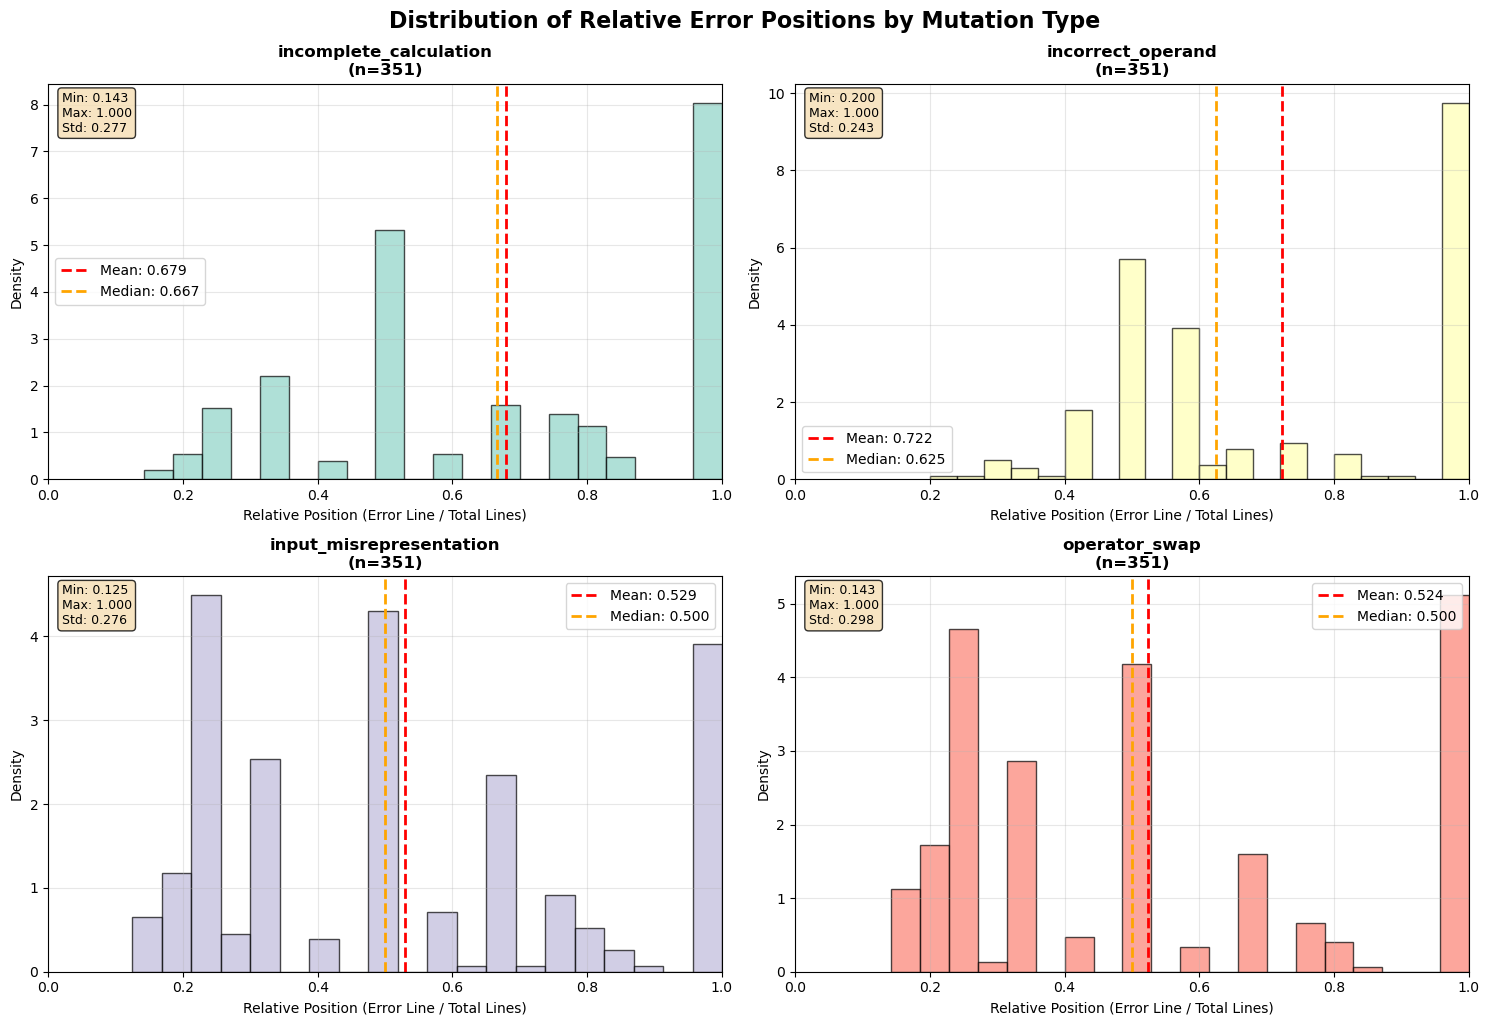

RELATIVE POSITION STATISTICS BY MUTATION TYPE

incomplete_calculation (n=351):
  Mean: 0.679
  Median: 0.667
  Std: 0.277
  Min: 0.143
  Max: 1.000
  25th percentile: 0.500
  75th percentile: 1.000

incorrect_operand (n=351):
  Mean: 0.722
  Median: 0.625
  Std: 0.243
  Min: 0.200
  Max: 1.000
  25th percentile: 0.500
  75th percentile: 1.000

input_misrepresentation (n=351):
  Mean: 0.529
  Median: 0.500
  Std: 0.276
  Min: 0.125
  Max: 1.000
  25th percentile: 0.250
  75th percentile: 0.690

operator_swap (n=351):
  Mean: 0.524
  Median: 0.500
  Std: 0.298
  Min: 0.143
  Max: 1.000
  25th percentile: 0.250
  75th percentile: 0.750


In [436]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_relative_position_distribution(df):
    """
    Creates histograms of relative erroneous line number positions by mutation type.
    """
    # Filter out rows without valid position ratios
    valid_data = df[df['error_position_ratio'].notna()].copy()
    
    # Get unique mutation types
    mutation_types = sorted(valid_data['mutation_type'].unique())
    
    # Set up the figure with subplots
    n_types = len(mutation_types)
    n_cols = 2
    n_rows = (n_types + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # If we have only one row, make sure axes is still a 2D array
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    # Color palette
    colors = plt.cm.Set3(range(n_types))
    
    for i, mutation_type in enumerate(mutation_types):
        ax = axes_flat[i]
        
        # Filter data for this mutation type
        type_data = valid_data[valid_data['mutation_type'] == mutation_type]['error_position_ratio']
        
        # Create histogram
        ax.hist(type_data, bins=20, alpha=0.7, color=colors[i], edgecolor='black', density=True)
        
        # Add statistics lines
        mean_val = type_data.mean()
        median_val = type_data.median()
        
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_val:.3f}')
        ax.axvline(median_val, color='orange', linestyle='--', linewidth=2,
                   label=f'Median: {median_val:.3f}')
        
        # Formatting
        ax.set_title(f'{mutation_type}\n(n={len(type_data)})', fontsize=12, fontweight='bold')
        ax.set_xlabel('Relative Position (Error Line / Total Lines)')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        
        # Add text box with statistics
        stats_text = f'Min: {type_data.min():.3f}\nMax: {type_data.max():.3f}\nStd: {type_data.std():.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Hide any extra subplots
    for i in range(n_types, len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Distribution of Relative Error Positions by Mutation Type', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    # Print summary statistics
    print("="*80)
    print("RELATIVE POSITION STATISTICS BY MUTATION TYPE")
    print("="*80)
    
    for mutation_type in mutation_types:
        type_data = valid_data[valid_data['mutation_type'] == mutation_type]['error_position_ratio']
        print(f"\n{mutation_type} (n={len(type_data)}):")
        print(f"  Mean: {type_data.mean():.3f}")
        print(f"  Median: {type_data.median():.3f}")
        print(f"  Std: {type_data.std():.3f}")
        print(f"  Min: {type_data.min():.3f}")
        print(f"  Max: {type_data.max():.3f}")
        print(f"  25th percentile: {type_data.quantile(0.25):.3f}")
        print(f"  75th percentile: {type_data.quantile(0.75):.3f}")

# Create the visualization
visualize_relative_position_distribution(FINAL_DF)